### Parabolic Time-Domain Radon Transform Demo

Radon operator `radon_tx_op(dt, h, q; href=href)`

- Forward is $ d(t,x) = \sum_q m(\tau = t - q (x/x_{ref})^2, q) $

- Adjoint is $ m'(\tau,q) = \sum_x d(t = \tau + q (x/x_{ref})^2, x) $


#### Forward Modeling with Radon and Wavelet Operators

In this example we formulate a forward model using MiniOps operators in order to define and solve a seismic inverse problem. The problem is the estimation of the Parabolic Radon Transform via inversion. 

We first construct the Radon operator in MiniOps, giving you the adjoint-consistent pair:

- `R`  : forward Radon transform  
- `R'` : adjoint Radon transform  

Julia definition:  
```julia
R = radon_tx_op(dt, h, q; href = href)
```
This operator pair is precisely what is required by iterative inverse solvers like `cgls` and `ista`, which rely on repeated evaluations of the forward and adjoint operators.

In addition to the Radon operator, we introduce a column-wise convolution operator:  
```julia
W = conv1d_cols_op(wavelet)
```
The latter allows us to have a composite operator to compute the data via the superposition of parabolic events that simulate an NMO-corrected CMP gather. So given the $m(\tau, q)$ panel the forward-modeled data are obtained via:  

```julia
d = W * R * m
```
Similarly, we can compute a low-resolution version of $m(\tau,q)$ via the adjoint operator:  
```julia
ma = R' * W' * d
```

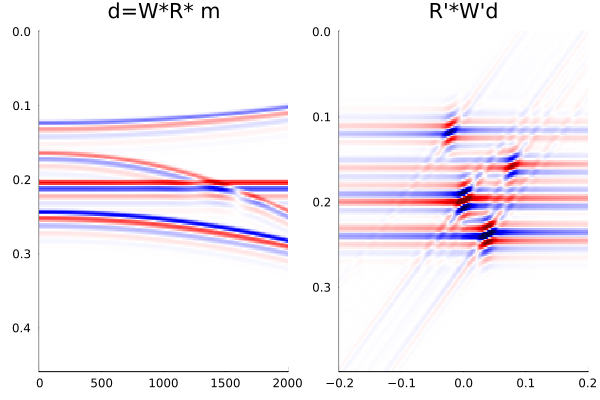

In [82]:
using MiniOps, Plots

# Define all necessary parameters

  dt = 0.002
   h = collect(0:1:200)*10.0
   q = collect(-100:1:100)*0.2/100
   w = seismic_wavelet(dt=dt,f0=50.0)
  nt = 200
  nq = size(q,1)
  nh = size(h,1)
href = maximum(h)

# Operators
  W = conv1d_cols_op(w)
  R = radon_tx_op(dt, h, q; href = href)

# Simple tau-q model 
  m = zeros(nt,size(q,1))
  m[100,101] =  1.0
  m[120,120] = -1.0
  m[ 60,90]  = -0.5
  m[ 80,140] =  0.5

# Compositive Operator
  A = W*R
  
# Foward Modelling and Adjoint Radon Panel
  d = A*m
  ma = A'*d

P1 = heatmap(h, (0:1:size(d,1)-1)*dt,d,   cmap=:seismic,  
             cbar=false,yflip=true, clim=(-1,1), title="d=W*R* m")
P2 = heatmap(q, (0:1:size(ma,1)-1)*dt,ma, cmap=:seismic,  
             cbar=false,yflip=true, clim=(-100,100),title="R'*W'd")
             
plot(P1,P2, layout=(1,2))

## Dot Product test 

In [83]:
 # Dot product test of WR (Convolution and Radon forward)
 
 adjoint_test(W*R, randn(size(m)), randn(size(d)); tol=1e-10)

(true, 1.0835486450063685e-15)

### L1–L2 Inversion via ISTA

Now we solve the problem by minimizing the cost function  

$$ J = \| A m - d \|_2^2 + \mu \| m \|_1 $$

where $ A = W R$.

We use `ista` and `opnorm_power` to compute the maximum eigenvalue of $ A' A$, which is needed to define the step length of `ista`. The resulting $\tau \text{–} q$ model obtained via inversion is then used to predict the data.



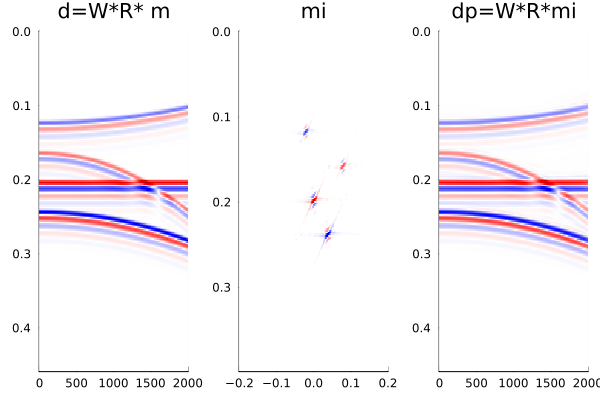

In [84]:
# Initial model and parameters 
 m0 = zeros(Float64, nt, nq)
 μ = 1.1
 e = opnorm_power(A, randn(nt,nq))
 η = 0.97/e^2
 mi = ista(A, d, m0, μ, η; niter = 300, verbose = false)

# Predicted data
  dp  = W*R*mi

P1 = heatmap(h, (0:1:size(d,1)-1)*dt,d,   cmap=:seismic,  
             cbar=false,yflip=true, clim=(-1,1), title="d=W*R* m")
P2 = heatmap(q, (0:1:size(mi,1)-1)*dt,mi, cmap=:seismic,  
             cbar=false,yflip=true, clim=(-.1,.1),title="mi")
P3 = heatmap(h, (0:1:size(dp,1)-1)*dt,dp, cmap=:seismic,  
             cbar=false,yflip=true, clim=(-1,1),title="dp=W*R*mi")          

             plot(P1, P2, P3, layout=(1,3), size = (600,400))